In [59]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

In [ ]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None): 
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist=(y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2 * math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)

data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
nll = data_loss_func(y, y_pred).mean()

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib.ticker import LogLocator
from matplotlib.ticker import LogLocator, FormatStrFormatter

importance sampling during training

Epoch 0, Total Loss: 0.419361
Epoch 100, Total Loss: 0.003171
Resampled collocation points at epoch 200
Epoch 200, Total Loss: 0.002546
Epoch 300, Total Loss: 0.000689
Resampled collocation points at epoch 400
Epoch 400, Total Loss: 0.003116
Epoch 500, Total Loss: 0.000387
Resampled collocation points at epoch 600
Epoch 600, Total Loss: 0.000435
Epoch 700, Total Loss: 0.000090
Resampled collocation points at epoch 800
Epoch 800, Total Loss: 0.000062
Epoch 900, Total Loss: 0.000024
Resampled collocation points at epoch 1000


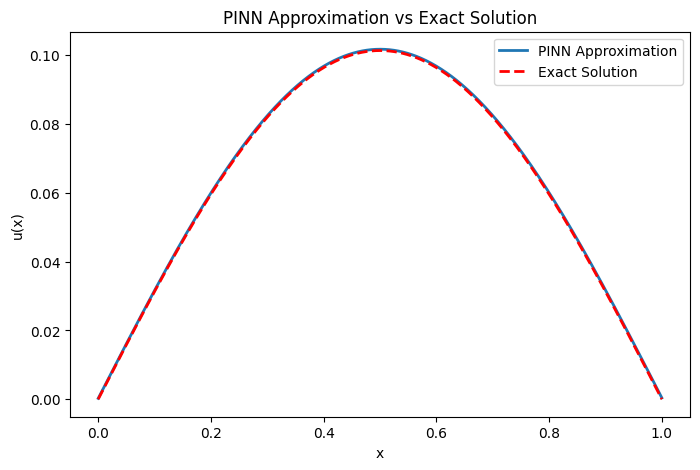

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network for the PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        # Create a fully connected network based on the provided layers list.
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = self.activation(layer(a))
        output = self.layers[-1](a)
        return output

# Define the PDE residual
def pde_residual(model, x):
    # Enable gradient tracking on x
    x.requires_grad = True
    u = model(x)
    # Compute first derivative u_x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Compute second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    # For this example, our PDE is: u_xx + sin(pi*x) = 0
    residual = u_xx + torch.sin(np.pi * x)
    return residual

# Generate initial collocation points uniformly in the domain [lb, ub]
def generate_collocation_points(n_points, lb, ub):
    x = np.random.uniform(lb, ub, (n_points, 1))
    return torch.tensor(x, dtype=torch.float32)

# Importance sampling: Evaluate the residual on a fine grid and sample new points
def importance_sampling(model, n_points, lb, ub):
    # Create a fine grid over the domain
    x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
    x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
    
    # Evaluate the residual on the fine grid
    residual = pde_residual(model, x_fine_tensor)
    res_val = residual.detach().abs().squeeze().numpy()  # absolute error
    # Avoid zero probabilities by adding a small epsilon
    eps = 1e-6
    weights = res_val + eps
    weights = weights / np.sum(weights)
    # Sample indices based on the residual weights
    indices = np.random.choice(len(x_fine), size=n_points, replace=True, p=weights)
    sampled_points = x_fine[indices]
    return torch.tensor(sampled_points, dtype=torch.float32)

# Hyperparameters and domain setup
lb, ub = 0.0, 1.0         # Domain boundaries
n_initial = 100           # Number of initial collocation points
n_epochs = 1000           # Total training epochs
sampling_interval = 200  # How often (in epochs) to update the collocation points
learning_rate = 1e-3      # Learning rate

# Define the network architecture (input, hidden layers, output)
layers = [1, 50, 50, 1]
model = PINN(layers)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# Generate the initial set of collocation points
collocation_points = generate_collocation_points(n_initial, lb, ub)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Compute the residual of the PDE at the collocation points
    residual = pde_residual(model, collocation_points)
    loss_res = mse_loss(residual, torch.zeros_like(residual))
    
    # (Optional) Include boundary conditions loss here.
    # For example, enforcing u(0)=0 and u(1)=0:
    x_bc = torch.tensor([[lb], [ub]], dtype=torch.float32)
    u_bc = model(x_bc)
    loss_bc = mse_loss(u_bc, torch.zeros_like(u_bc))
    
    loss = loss_res + loss_bc
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")
    
    # Every sampling_interval epochs, perform importance sampling to update collocation points.
    if (epoch + 1) % sampling_interval == 0:
        collocation_points = importance_sampling(model, n_initial, lb, ub)
        print(f"Resampled collocation points at epoch {epoch+1}")

# After training, evaluate the model on a fine grid and plot the results.
x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
model.eval()
with torch.no_grad():
    u_pred = model(x_fine_tensor).detach().cpu().numpy()

# Exact solution: u(x) = (1/pi^2)*sin(pi*x) with u(0)=u(1)=0.
u_exact = (1/np.pi**2) * np.sin(np.pi * x_fine)

plt.figure(figsize=(8, 5))
plt.plot(x_fine, u_pred, label='PINN Approximation', linewidth=2)
plt.plot(x_fine, u_exact, 'r--', label='Exact Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('PINN Approximation vs Exact Solution')
plt.show()


## Deep reasearch chatGPT

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd

# Define PINN architecture: input (t, params) -> output u
class PINN(nn.Module):
    def __init__(self, param_dim, hidden_dim=50, layers=4):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        input_dim = 1 + param_dim  # time + parameters
        # Build a simple feedforward network
        self.net.add_module('input_layer', nn.Linear(input_dim, hidden_dim))
        self.net.add_module('input_act', nn.Tanh())
        for i in range(layers-1):
            self.net.add_module(f'h{i}_layer', nn.Linear(hidden_dim, hidden_dim))
            self.net.add_module(f'h{i}_act', nn.Tanh())
        self.net.add_module('output_layer', nn.Linear(hidden_dim, 1))
    def forward(self, t, params):
        # t: tensor of shape [N, 1], params: tensor of shape [N, param_dim]
        inp = torch.cat([t, params], dim=1)
        return self.net(inp)

# Initialize model, optimizer
param_dim = 5  # e.g., (m, c, k, u0, v0)
model = PINN(param_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Sample initial collocation points
N_collocation = 10000
# Randomly sample parameter values from prior (assuming normal or uniform for example)
params_samples = sample_parameter_distribution(N_collocation, param_dim)  # user-defined
# Randomly sample times in [0, T]
t_samples = torch.rand(N_collocation, 1) * T_max

# Prepare initial condition values corresponding to params_samples (u0 and v0 are part of params)
# We assume params_samples includes u0 and v0 as components.

# Training loop (simplified)
for epoch in range(initial_epochs):
    optimizer.zero_grad()
    # Pick a batch of collocation points (for simplicity, use all here)
    t_batch = t_samples
    x_batch = params_samples
    # Forward pass
    u_pred = model(t_batch, x_batch)            # predicted u(t)
    # Compute time derivatives for physics residual using autograd
    u_pred_t = autograd.grad(u_pred, t_batch, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_tt = autograd.grad(u_pred_t, t_batch, grad_outputs=torch.ones_like(u_pred_t), create_graph=True)[0]
    # Compute physics residual for harmonic oscillator: m*u_tt + c*u_t + k*u = 0
    m = x_batch[:,0:1]; c = x_batch[:,1:2]; k = x_batch[:,2:3]   # assuming param ordering [m,c,k,u0,v0]
    physics_residual = m*u_pred_tt + c*u_pred_t + k*u_pred
    L_phys = torch.mean(physics_residual**2)
    # Initial condition loss for this batch (for t=0, enforce u = u0 and u_t = v0)
    # Need to filter those points where t is 0 (we can include explicit t=0 points in training set)
    # For simplicity, we'll separately enforce initial conditions:
    u0 = x_batch[:,3:4]; v0 = x_batch[:,4:5]  # initial disp and velocity from params
    # Mask for t=0 points:
    mask = (t_batch == 0).squeeze()
    L_ic = torch.tensor(0.0)
    if mask.any():
        u_pred0 = u_pred[mask]
        u_pred0_t = u_pred_t[mask]
        L_ic = torch.mean((u_pred0 - u0[mask])**2 + (u_pred0_t - v0[mask])**2)
    # Total loss
    loss = L_phys + L_ic
    loss.backward()
    optimizer.step()


## BC trick

Epoch 0, Loss: 1.710518e+00
Epoch 499, Loss: 1.084070e-03


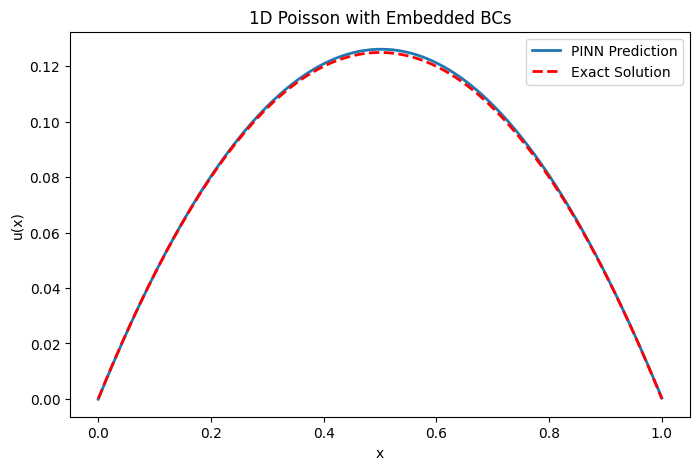

Mean absolute error: 6.207971e-04


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1) Define a small MLP
# -----------------------
class MLP(nn.Module):
    def __init__(self, layers):
        """
        layers: list of integers, e.g. [1, 32, 32, 1]
                meaning 1 input, two hidden layers of size 32, and 1 output.
        """
        super(MLP, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the MLP.
        x: tensor of shape (N, 1) for 1D input.
        """
        # Pass through all but the last layer with activation
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        # Last layer (linear only)
        x = self.linears[-1](x)
        return x

# ---------------------------------------------------------
# 2) Define the "physics-based" solution that embeds BCs
# ---------------------------------------------------------
def pinn_solution(model, x):
    """
    Returns the solution that automatically satisfies u(0)=0 and u(1)=0:
        u(x) = x(1-x)*model(x)
    """
    return model(x) #* (x * (1.0 - x))

# -----------------------------------
# 3) Define the PDE residual
# -----------------------------------
def pde_residual(model, x):
    """
    For PDE: u''(x) = -1 on [0,1], with u(0)=0, u(1)=0.
    Residual: R(x) = u''(x) + 1 = 0
    """
    # Enable gradient tracking
    x.requires_grad = True

    # Compute the "physics-based" output that satisfies BC
    u = pinn_solution(model, x)

    # First derivative u_x
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    # Second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE: u''(x) + 1 = 0 => residual = u_xx + 1
    residual = u_xx + 1.0
    return residual

def boundary_loss(model, x):
    """
    Loss for enforcing boundary conditions u(0)=0 and u(1)=0.
    """
    u = pinn_solution(model, x)
    return torch.mean(u**2)

# -------------------------------------------------
# 4) Create training data and train the PINN
# -------------------------------------------------
if __name__ == "__main__":
    # Hyperparameters
    N_collocation = 100      # number of collocation points
    layers = [1, 32, 32, 1]  # MLP architecture
    lr = 1e-3                # learning rate
    epochs = 500          # training epochs

    # Create model
    model = MLP(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Generate random collocation points in [0,1]
    x_coll = np.random.rand(N_collocation, 1)
    x_coll_torch = torch.tensor(x_coll, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute PDE residual at collocation points
        res = pde_residual(model, x_coll_torch)

        # MSE of residual => we want residual ~ 0
        loss = mse_loss(res, torch.zeros_like(res)) + 10*boundary_loss(model, torch.zeros_like(res)) + 10*boundary_loss(model, torch.ones_like(res))
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

    # ---------------------------------------------

    # 5) Evaluate & compare to exact solution
    # ---------------------------------------------
    model.eval()
    x_test = np.linspace(0, 1, 200).reshape(-1, 1)
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    with torch.no_grad():
        u_pred = pinn_solution(model, x_test_torch).numpy()
    print(f"Epoch {epoch}, Loss: {loss.item():.6e}")
    # Exact solution: u_exact(x) = -(x^2)/2 + (x/2)
    u_exact = -0.5 * x_test**2 + 0.5 * x_test

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(x_test, u_pred, label='PINN Prediction', linewidth=2)
    plt.plot(x_test, u_exact, 'r--', label='Exact Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Poisson with Embedded BCs')
    plt.legend()
    plt.show()

    #error from exact solution
    error = np.abs(u_exact - u_pred)
    print(f"Mean absolute error: {np.mean(error):.6e}")


Epoch 0, Loss: 7.637299e-01
Epoch 499, Loss: 4.539709e-06


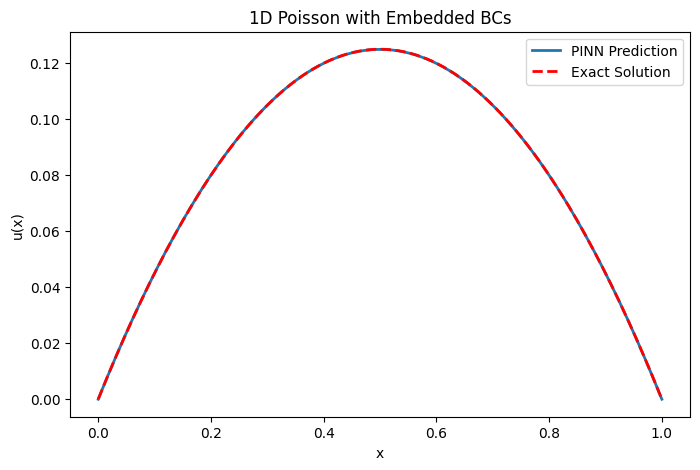

Mean absolute error: 2.582344e-05


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1) Define a small MLP
# -----------------------
class MLP(nn.Module):
    def __init__(self, layers):
        """
        layers: list of integers, e.g. [1, 32, 32, 1]
                meaning 1 input, two hidden layers of size 32, and 1 output.
        """
        super(MLP, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the MLP.
        x: tensor of shape (N, 1) for 1D input.
        """
        # Pass through all but the last layer with activation
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        # Last layer (linear only)
        x = self.linears[-1](x)
        return x

# ---------------------------------------------------------
# 2) Define the "physics-based" solution that embeds BCs
# ---------------------------------------------------------
def pinn_solution(model, x):
    """
    Returns the solution that automatically satisfies u(0)=0 and u(1)=0:
        u(x) = x(1-x)*model(x)
    """
    return model(x) * (x * (1.0 - x))

# -----------------------------------
# 3) Define the PDE residual
# -----------------------------------
def pde_residual(model, x):
    """
    For PDE: u''(x) = -1 on [0,1], with u(0)=0, u(1)=0.
    Residual: R(x) = u''(x) + 1 = 0
    """
    # Enable gradient tracking
    x.requires_grad = True

    # Compute the "physics-based" output that satisfies BC
    u = pinn_solution(model, x)

    # First derivative u_x
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    # Second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE: u''(x) + 1 = 0 => residual = u_xx + 1
    residual = u_xx + 1.0
    return residual

# -------------------------------------------------
# 4) Create training data and train the PINN
# -------------------------------------------------
if __name__ == "__main__":
    # Hyperparameters
    N_collocation = 100      # number of collocation points
    layers = [1, 32, 32, 1]  # MLP architecture
    lr = 1e-3                # learning rate
    epochs = 500          # training epochs

    # Create model
    model = MLP(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Generate random collocation points in [0,1]
    x_coll = np.random.rand(N_collocation, 1)
    x_coll_torch = torch.tensor(x_coll, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute PDE residual at collocation points
        res = pde_residual(model, x_coll_torch)

        # MSE of residual => we want residual ~ 0
        loss = mse_loss(res, torch.zeros_like(res)) #+ boundary_loss(model, torch.zeros_like(res)) + boundary_loss(model, torch.ones_like(res))
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

    # ---------------------------------------------

    # 5) Evaluate & compare to exact solution
    # ---------------------------------------------
    model.eval()
    x_test = np.linspace(0, 1, 200).reshape(-1, 1)
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    with torch.no_grad():
        u_pred = pinn_solution(model, x_test_torch).numpy()
    print(f"Epoch {epoch}, Loss: {loss.item():.6e}")
    # Exact solution: u_exact(x) = -(x^2)/2 + (x/2)
    u_exact = -0.5 * x_test**2 + 0.5 * x_test

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(x_test, u_pred, label='PINN Prediction', linewidth=2)
    plt.plot(x_test, u_exact, 'r--', label='Exact Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Poisson with Embedded BCs')
    plt.legend()
    plt.show()

    #error from exact solution
    error = np.abs(u_exact - u_pred)
    print(f"Mean absolute error: {np.mean(error):.6e}")


### Harmonic oscillator

In [82]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_fixed(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_fixed, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        m_  = m.expand(N, -1)
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m_, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

def pinn_solution(model, t, m, mu, k, y0, v0):
    return model(t, m, mu, k, y0, v0) * t**2 + v0*t + y0

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = pinn_solution(model, t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2) 


def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": []}
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde 
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}")
                plot_loss(range(epoch + 1), self.losses)

Epoch 0, PDE loss: 2160.519775390625


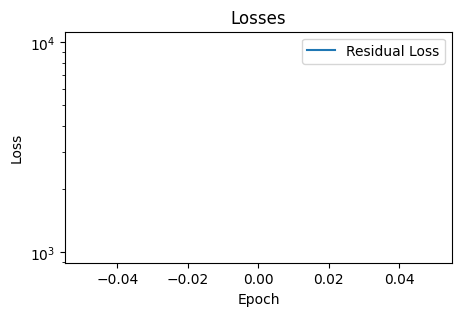

Epoch 1000, PDE loss: 3.861046552658081


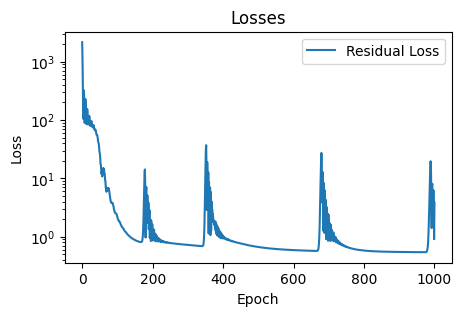

Epoch 2000, PDE loss: 0.4846944808959961


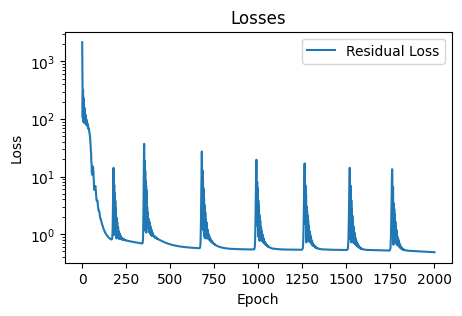

Epoch 3000, PDE loss: 0.08022498339414597


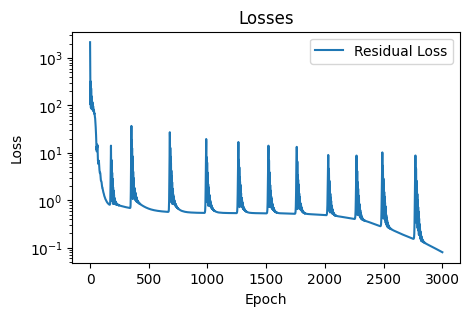

Epoch 4000, PDE loss: 0.00890274066478014


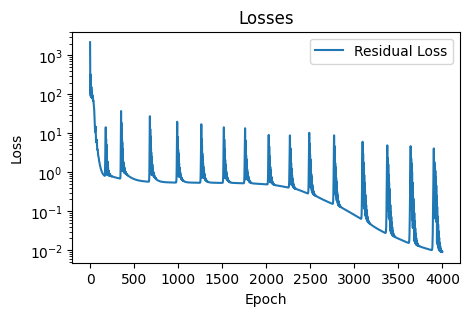

In [90]:
def initialize_fixed_parameters(Num=500):
    t_coll = torch.linspace(0, 5, steps=Num).view(-1,1)
    t_coll.requires_grad_(True)
    
    m, mu, k = 1.0, 0.6, 5.0
    y0, v0 = -0.4, 3.0
    
    m_val  = torch.tensor([[m]], requires_grad=True)
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val  = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)
    
    t0 = torch.tensor([0.0]).view(-1,1).requires_grad_(True)
    
    return t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
# set_seed()
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_fixed_parameters()
fixed_model = PINN_fixed(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(fixed_model.parameters(), lr=0.01)
trainer = Trainer(fixed_model, optimizer)
trainer.train(t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0)

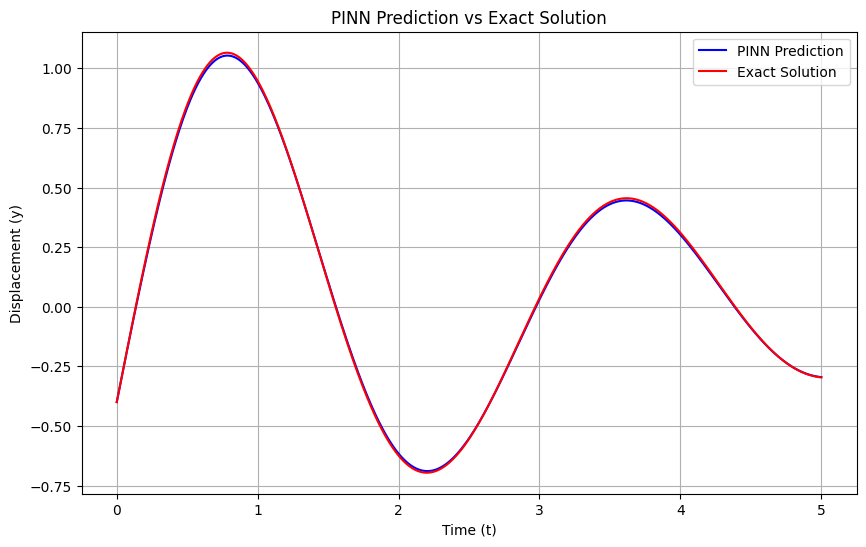

In [91]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

# plot the model prediction
t_test = torch.linspace(0, 5, 1000).view(-1, 1)
y_pred = pinn_solution(fixed_model, t_test, m_val, mu_val, k_val, y0_val, v0_val)
y_exact = damped_harmonic_oscillator(t_test)

plt.figure(figsize=(10, 6))
plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='PINN Prediction', color='blue')
plt.plot(t_test.detach().numpy(), y_exact, label='Exact Solution', color='red')
plt.title('PINN Prediction vs Exact Solution')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

Epoch 0, PDE loss: 1523.6072998046875


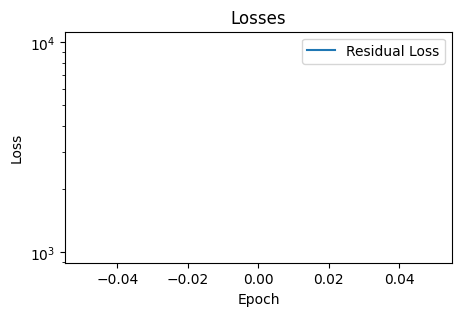

Epoch 1000, PDE loss: 1.1767754554748535


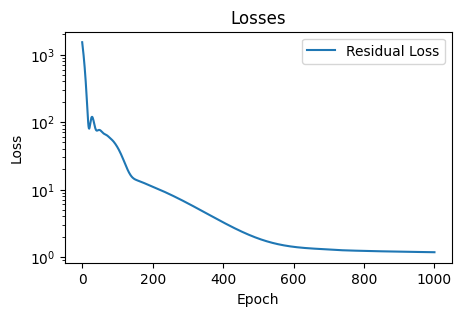

Epoch 2000, PDE loss: 0.7972697019577026


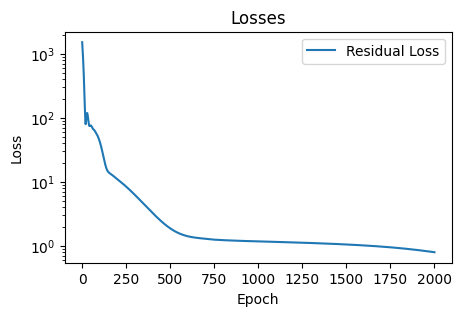

Epoch 3000, PDE loss: 0.4285792410373688


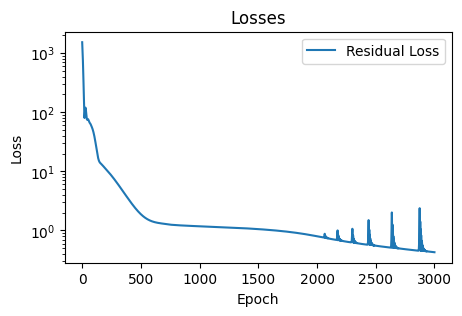

Epoch 4000, PDE loss: 0.28681233525276184


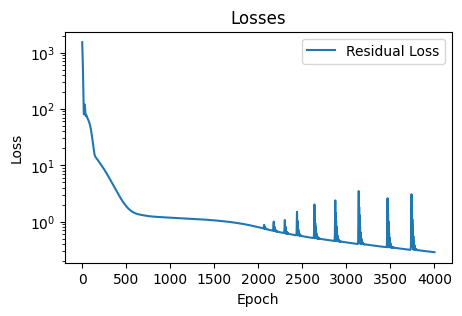

In [92]:
class PINN_gaussian_mass(PINN_fixed):  
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

# Initialize training parameters
def initialize_uniform_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()
uniform_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(uniform_mass_model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)

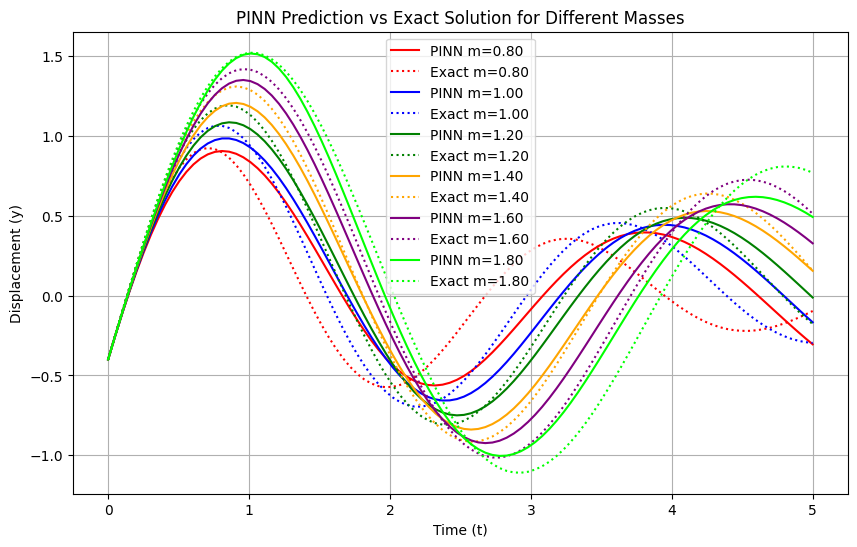

Mass = 0.80, MSE = 1.977123
Mass = 1.00, MSE = 2.038573
Mass = 1.20, MSE = 2.105554
Mass = 1.40, MSE = 2.156698
Mass = 1.60, MSE = 2.173213
Mass = 1.80, MSE = 2.148587

Combined Mean Squared Error over all masses: 2.099958


In [94]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = pinn_solution(uniform_mass_model,t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

Epoch 0, PDE loss: 2118.527587890625


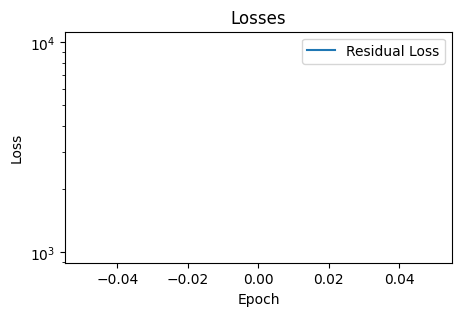

Epoch 1000, PDE loss: 2.538699150085449


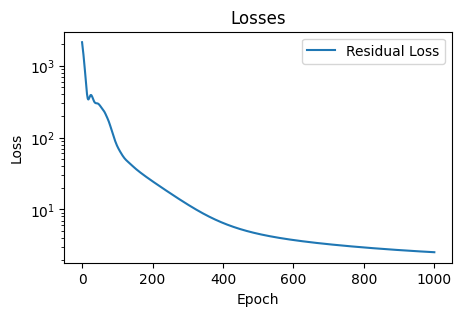

Epoch 2000, PDE loss: 2.032404899597168


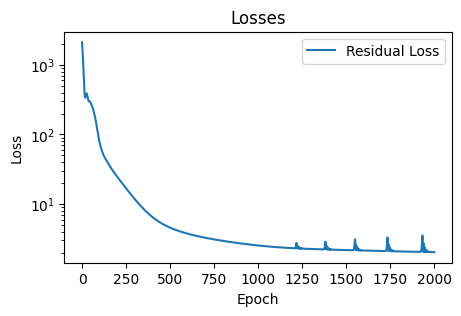

Epoch 3000, PDE loss: 1.8116079568862915


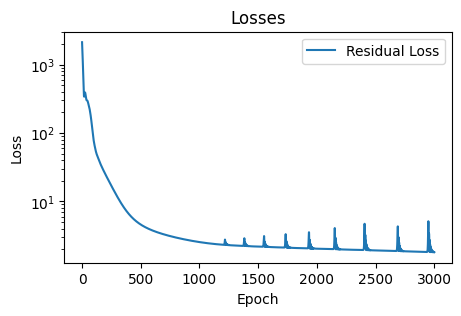

Epoch 4000, PDE loss: 1.5228163003921509


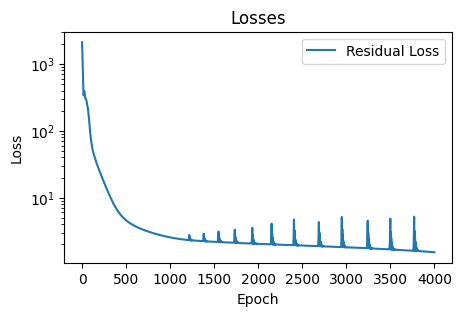

Epoch 5000, PDE loss: 1.1885285377502441


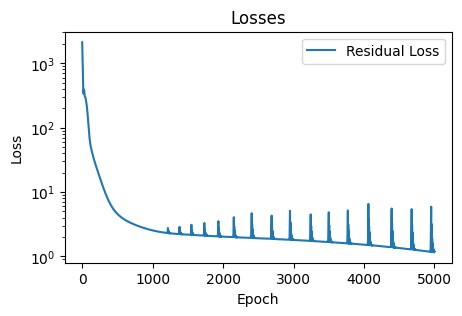

Epoch 6000, PDE loss: 0.8518446087837219


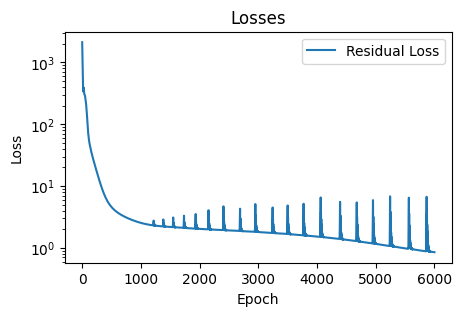

Epoch 7000, PDE loss: 0.7027899622917175


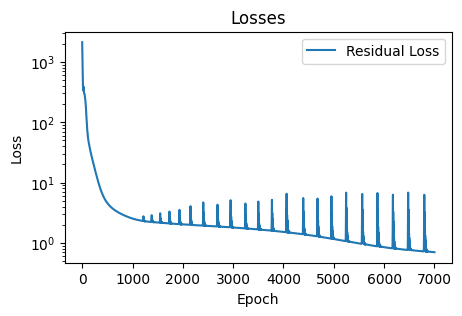

Epoch 8000, PDE loss: 0.6197184920310974


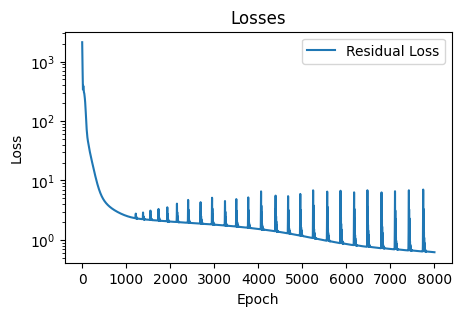

Epoch 9000, PDE loss: 0.5634992718696594


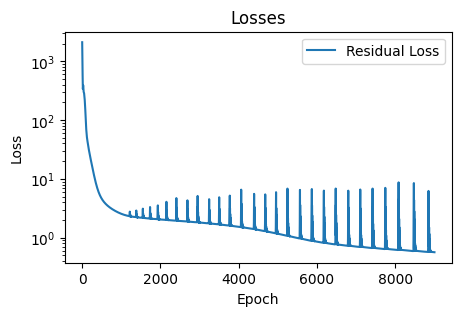

Epoch 10000, PDE loss: 0.5159374475479126


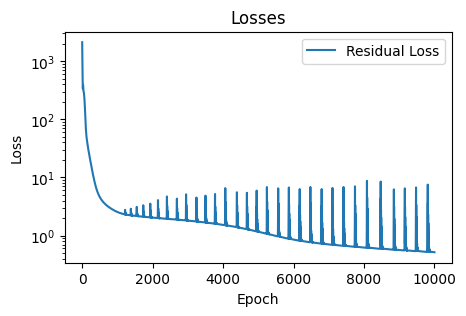

Epoch 11000, PDE loss: 0.47169893980026245


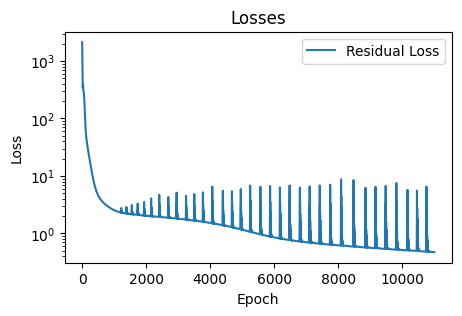

Epoch 12000, PDE loss: 0.4343821406364441


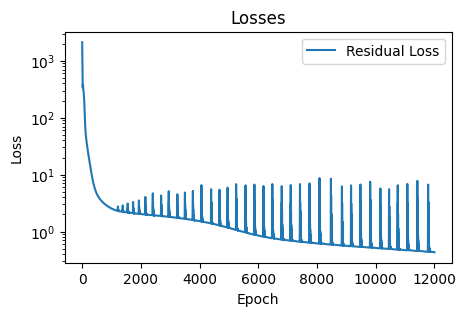

Epoch 13000, PDE loss: 0.39415228366851807


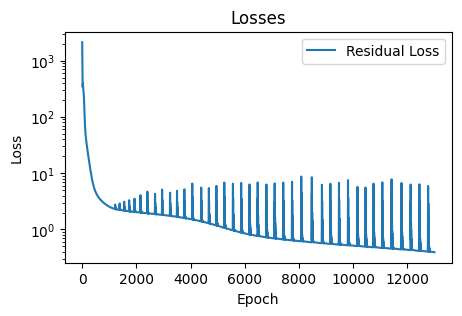

Epoch 14000, PDE loss: 0.5815370678901672


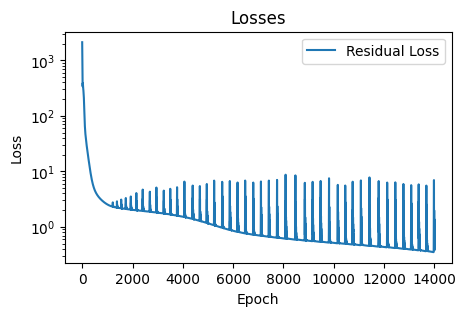

Epoch 15000, PDE loss: 0.311665415763855


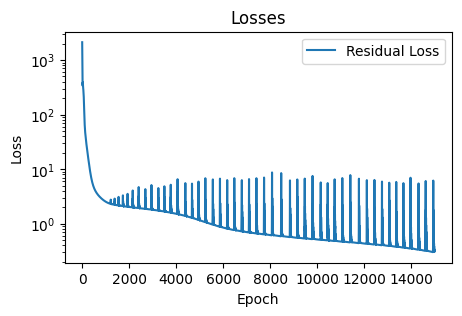

Epoch 16000, PDE loss: 0.2520299255847931


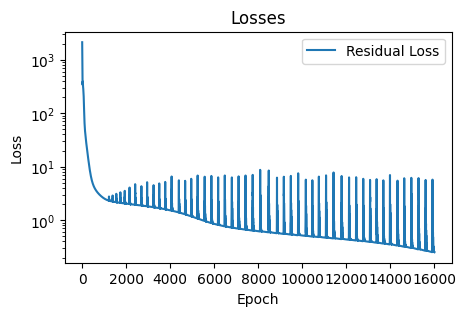

Epoch 17000, PDE loss: 0.21074412763118744


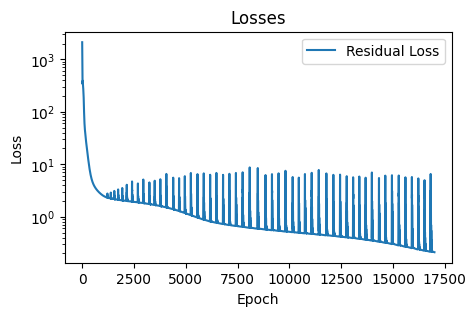

Epoch 18000, PDE loss: 0.18511678278446198


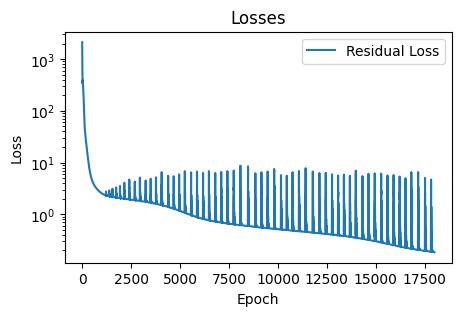

Epoch 19000, PDE loss: 0.16732995212078094


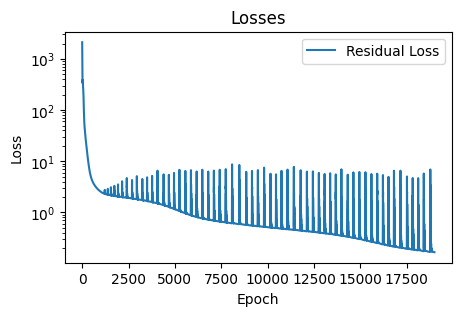

Epoch 20000, PDE loss: 0.15169638395309448


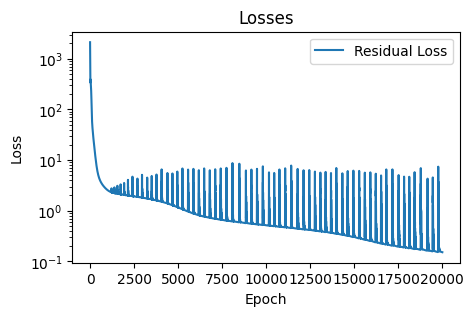

In [95]:
# Define the PINN model
class PINN_all(PINN_fixed):  
    def forward(self, t, m, mu, k, y0, v0):
        x = torch.cat([t, m, mu, k, y0, v0], dim=1)
        return self.net(x)

# Initialize training parameters
def initialize_uniform_all():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    mu_mean, mu_std = 0.6, 0.1
    k_mean, k_std = 5.0, 0.5
    y0_mean, y0_std = -0.4, 0.1
    v0_mean, v0_std = 3.0, 0.5
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k_coll = torch.FloatTensor(N, 1).uniform_(k_mean - 2 * k_std, k_mean + 4 * k_std)
    k_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    y0_coll = torch.FloatTensor(N, 1).uniform_(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std)
    y0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    v0_coll = torch.FloatTensor(N, 1).uniform_(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std)
    v0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0 = initialize_uniform_all()
uniform_all_model = PINN_all(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(uniform_all_model.parameters(), lr=0.001)
trainer = Trainer(uniform_all_model, optimizer,epochs=20001)
trainer.train(t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0)

In [96]:
import itertools
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.1
k_mean, k_std = 5.0, 0.5
y0_mean, y0_std = -0.4, 0.1
v0_mean, v0_std = 3.0, 0.5
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 4 * m_std, 6)
mu_values = np.linspace(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std, 6)
k_values = np.linspace(k_mean - 2 * k_std, k_mean + 4 * k_std, 6)
y0_values = np.linspace(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std, 6)
v0_values = np.linspace(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std, 6)


t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values, k_values, y0_values, v0_values))

for combo in combos:
    m_val_combo, mu_val_combo, k_val_combo, y0_val_combo, v0_val_combo = combo
    # Create a test tensor for each parameter with length equal to t_test
    m_test = torch.tensor([m_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    mu_test = torch.tensor([mu_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    k_test = torch.tensor([k_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    y0_test = torch.tensor([y0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    v0_test = torch.tensor([v0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    
    # Get the PINN prediction
    y_pred = pinn_solution(uniform_all_model,t_test, m_test, mu_test, k_test, y0_test, v0_test)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         m=m_val_combo, mu=mu_val_combo, 
                                         k=k_val_combo, y0=y0_val_combo, 
                                         v0=v0_val_combo)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu, k, y0, v0)=({m_val_combo:.2f}, {mu_val_combo:.2f}, {k_val_combo:.2f}, {y0_val_combo:.2f}, {v0_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")



Combined Mean Squared Error over all combinations: 0.029144
